# Exploring Changes in Phoenix Biodiversity

*Author: Haylee Oyler*

[Link to GitHub repository](https://github.com/haylee360/phoenix-biodiversity)

## About

#### Purpose
This analysis explores the changes in biodiversity intactness in the Phoenix metropolitan area. Maricopa county, which Phoenix resides in, was identified as the U.S. county with the most significant increased in developed area since 2001. This rapid urban sprawl has profound implications for biodiversity and the health of surrounding natural ecosystems.

This project will investigate the impacts of urbanization by utilizing a dataset of Biodiversity Intactness Indeces (BII).

#### Highlights
- Load Phoenix shapefile using `geopandas`
- Access BII data using the `planetary_computer` and `pystac_client` packages
- Explore the properties of the BII data
- Visualize the BII data using `IPython.display`
- Create a map of the Phoenix metropolitan area using `matplotlib` and `contextily`
- Clip the BII data to the phoenix subdivision shapefile using `rioxarray`
- Calculate the percent BII greater than 0.75 in 2017 and 2020
- Map the phoenix area showing the lost in BII greater than 0.75 from 2017 to 2020 using `matplotlib` 

#### About the Data
This project uses Biodiversity intactness index data from Microsoft's planetaray computer. We access the specific collection `io-biodiversity` from the STAC catalog. 

This project also uses Arizona county border data from the U.S. Census Burea. This is to help us better visualize the change in biodiversity intactness index in our area of interest. 

#### References
[Biodiversity Intactness Index](https://planetarycomputer.microsoft.com/dataset/io-biodiversity) 

- Microsoft Planetary Computer. Biodiversity Intactness STAC collection available via https://planetarycomputer.microsoft.com/dataset/io-biodiversity. Accesssed December 4 2024. 


[Arizona counties data](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions)

- United States Census Bureau. (2022). Arizona County Subdivision 2022 TIGER/Line Shapefiles. [Data File]. U.S. Census Bureau, Geography Division. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions Accessed 4 December 2024.

#### Acknowledgements
All materials were created by [Carmen Galaz-Garcia](https://github.com/carmengg) for [EDS-220: Working with Environmental Data](https://meds-eds-220.github.io/MEDS-eds-220-course/).

In [1]:
# Load packages 
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # To create a custom legend
import geopandas as gpd
import pandas as pd
import rioxarray as rioxr
import xarray as xr
import contextily as cx

from pystac_client import Client  # To access STAC catalogs

import planetary_computer  # To sign items from the MPC STAC catalog 

from IPython.display import Image  # To nicely display images

# Import arizona county boundaries data
arizona_boundaries = gpd.read_file(os.path.join("data", "tl_2020_04_cousub.shp"))

## Access the MPC catalog and explore

In [2]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [3]:
# Explore catalog metadata
print('Title:', catalog.title)
print('Description:', catalog.description)

Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


In [4]:
catalog.get_collections()

<generator object Client.get_collections at 0x17991bbc0>

In [5]:
# Get collections and print their names
collections = list(catalog.get_collections())  # Turn generator into list

print('Number of collections:', len(collections))

print("Collections IDs (first 10):")
for i in range(10):
    print('-', collections[i].id)

Number of collections: 124
Collections IDs (first 10):
- daymet-annual-pr
- daymet-daily-hi
- 3dep-seamless
- 3dep-lidar-dsm
- fia
- sentinel-1-rtc
- gridmet
- daymet-annual-na
- daymet-monthly-na
- daymet-annual-hi


## Define parameters for our search

In [6]:
# Temporal range of interest
time_range = "2017-01-01/2023-01-01"

# bounding box (as a GeoJSON)
bbox = {
    "type": "Polygon",
    "coordinates":[
        [
            [-112.826843, 33.863574],
            [-112.826843, 32.974108],
            [-111.184387, 32.974108],
            [-111.184387, 33.863574],
            [-112.826843, 33.863574]
        ]
    ],
}


In [7]:
# Catalog search
search = catalog.search(
    collections = ['io-biodiversity'],
    intersects = bbox,
    datetime = time_range)
search

In [8]:
# Retrieve search items
items = search.item_collection()
items

In [9]:
# Get first item in the catalog search
item_2020 = items[0]
item_2017 = items[3]


In [10]:
# Print item ID and properties
# print('ID:' , item.id)
# item_2017.properties

In [11]:
item_2017.assets

{'data': <Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2017/bii_2017_34.74464974521749_-115.38597824385106_cog.tif?st=2024-12-05T03%3A23%3A36Z&se=2024-12-06T04%3A08%3A36Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-12-06T01%3A20%3A08Z&ske=2024-12-13T01%3A20%3A08Z&sks=b&skv=2024-05-04&sig=7rP6J6aUDjtf05vsqhaSM7FMDN/0hhTzCv%2BNMyU2sd4%3D>,
 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=io-biodiversity&item=bii_2017_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png>,
 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=io-biodiversity&item=bii_2017_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.

In [12]:
# Plot rendered preview
Image(url=item_2020.assets['rendered_preview'].href, width=500)

## Load data

In [13]:
# Open the raster data from our 2017 and 2020 items
phoenix_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)
phoenix_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)

In [14]:
# Filter our arizona shapefile to just the phoenix area
phoenix_shp = arizona_boundaries[arizona_boundaries['NAME'] == 'Phoenix']

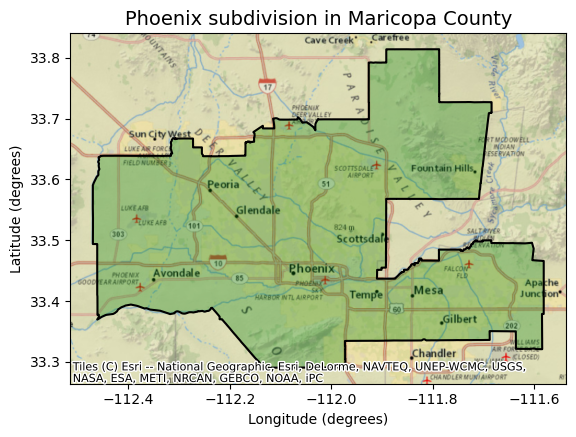

In [15]:
# Initialize figure
fig, ax = plt.subplots()

#Plot phoenix boundary
phoenix_shp.boundary.plot(ax=ax,
                edgecolor='black')

# Plot phoenix fill
phoenix_shp.plot(ax=ax, 
                color='green',
                alpha=0.3)

# Plot background data
cx.add_basemap(ax=ax, 
            crs=arizona_boundaries.crs, 
            source=cx.providers.Esri.NatGeoWorldMap)

# Set title and axes labels
ax.set_title('Phoenix subdivision in Maricopa County',
            fontsize=14)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

plt.show()

In [16]:
# Match the CRS of the phoenix shapefile to the raster data
phoenix_shp = phoenix_shp.to_crs('EPSG:4326')
assert phoenix_2017.rio.crs == phoenix_shp.crs
assert phoenix_2020.rio.crs == phoenix_shp.crs


In [17]:
# Assign empty cells to nan
phoenix_2017 = phoenix_2017.rio.write_nodata(np.nan)

# Clip the 2017 raster to the phoenix bounding box
phoenix_2017_clip = (phoenix_2017.rio.clip_box(*phoenix_shp.total_bounds)
                    .rio.clip(phoenix_shp.geometry)
                    )


In [18]:
# Assign empty cells to nan
phoenix_2020 = phoenix_2020.rio.write_nodata(np.nan)

# Clip the 2017 raster to the phoenix bounding box
phoenix_2020_clip = (phoenix_2020.rio.clip_box(*phoenix_shp.total_bounds)
                    .rio.clip(phoenix_shp.geometry)
                    )

## Biodiversity Intactness Index percentage area

In [41]:
# Reproject to the correct CRS for Arizona
phoenix_shp = phoenix_shp.to_crs('EPSG:2223')
phoenix_2017_clip = phoenix_2017_clip.rio.reproject('EPSG:2223')
phoenix_2020_clip = phoenix_2020_clip.rio.reproject('EPSG:2223')

In [52]:
# Sum the number of pixels above 0.75 for each year
area_bii_2017 = (phoenix_2017_clip >= 0.75).sum().item()
area_bii_2020 = (phoenix_2020_clip >= 0.75).sum().item()

In [ ]:
# Sum the number of pixels total for each year
total_bii_2017 = phoenix_2017_clip.sum().item()
total_bii_2020 = phoenix_2020_clip.sum().item()

In [59]:
# Calculate the percentage of the total area 
percentage_bii_2017 = (area_bii_2017 / total_bii_2017) * 100
percentage_bii_2020 = (area_bii_2020 / total_bii_2020) * 100

print(f"Percentage of area with BII >= 0.75 in 2017: {percentage_bii_2017:.2f}%")
print(f"Percentage of area with BII >= 0.75 in 2020: {percentage_bii_2020:.2f}%")

Percentage of area with BII >= 0.75 in 2017: 18.65%
Percentage of area with BII >= 0.75 in 2020: 17.18%


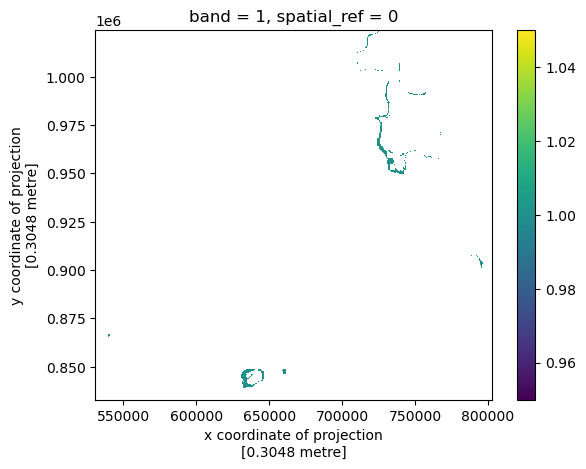

In [54]:
# Find the difference between areas >= 0.75 between 2017 and 2020 
phx_diff = (phoenix_2017_clip >= 0.75) ^ (phoenix_2020_clip >= 0.75)

# Assign zeroes to nan
phx_diff = xr.where(phx_diff, 1, np.nan)

phx_diff.plot()

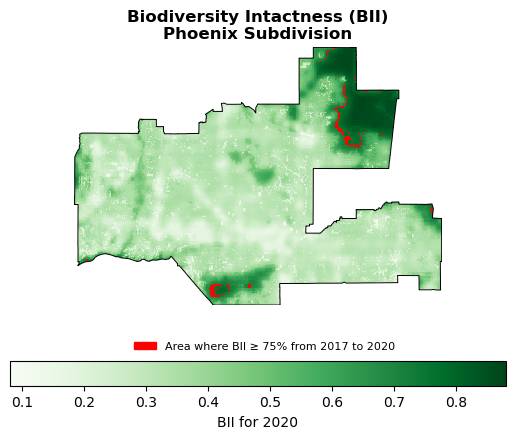

In [60]:
# Initialize figure
fig, ax = plt.subplots()

# Turn axis off for cleaner map
ax.axis('off')

#Plot phoenix boundary
phoenix_shp.boundary.plot(ax=ax,
                        edgecolor='black',
                        linewidth=0.7)

# Plot BII
phoenix_2020_clip.plot(ax=ax,
                        cmap='Greens',
                        cbar_kwargs = {'location':'bottom', # for intuitive biodiversity sense
                                        'label': 'BII for 2020'})

# Plot difference in BII
phx_diff.plot(ax=ax, 
                cmap='brg',
                add_colorbar=False)

# Create custom legend for the BII difference
bii_diff_leg = mpatches.Patch(color = "red", label = 'Area where BII ≥ 75% from 2017 to 2020')

ax.legend(handles = [bii_diff_leg], 
        fontsize = 8, 
        frameon=False, 
        bbox_to_anchor=(0.9, -0.1))

# Set title and axes labels
ax.set_title('Biodiversity Intactness (BII)\nPhoenix Subdivision',
                fontsize=12, fontweight='bold')
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

plt.show()
